# MissOh DataLoader

### AnotherMissOh Visual Structure
- json_data['file_name'] : 'AnotherMissOh01.mp4'
- json_data['visual_results']
- json_data['visual_results'][0].keys() : dict_keys(['start_time', 'end_time', 'vid', 'image_info'])
- {
'start_time': '00:02:51;16', 
'end_time': '00:02:54;15', 
'vid': 'AnotherMissOh01_001_0078', 
'image_info': ...}
- json_data['visual_results'][0]['image_info']
- [{'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004295', 
'place': 'none', 
'persons': [
{'person_id': 'Haeyoung1', 
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 845, 'max_y': 443}, 
'full_rect': {'min_x': 278, 'min_y': 2, 'max_x': 1025, 'max_y': 769}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}], 
'objects': []}, 
- {'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004311', 
'place': '', 
'persons': [{
'person_id':'Haeyoung1',
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 831, 'max_y': 411}, 
'full_rect': {'min_x': 270, 'min_y': 0, 'max_x': 1025, 'max_y': 768}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}],
'objects': []},]

In [36]:
# !apt-get install graphviz xdg-utils

In [37]:
import sys
sys.path.append("../") # go to parent dir

In [38]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import pickle
import numpy as np
import glob
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import json
import argparse
import matplotlib.pyplot as plt

from Yolo_v2_pytorch.src.utils import *
from graphviz import Digraph, Graph

In [39]:
def is_not_blank(s):
    return bool(s and s.strip())

In [40]:
MissOh_CLASSES = ['person']
print(MissOh_CLASSES[0])
global colors
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))
print(colors[0])

person
(39, 129, 113)


In [41]:
def get_args():
    parser = argparse.ArgumentParser(
        "You Only Look Once:Unified, Real-Time Object Detection")
    parser.add_argument("--image_size", type=int,
                        default=448,
                        help="The common width and height for all images")
    parser.add_argument("--batch_size", type=int, default=1,
                        help="The number of images per batch")
    # Training base Setting
    parser.add_argument("--momentum", type=float, default=0.9)
    parser.add_argument("--decay", type=float, default=0.0005)
    parser.add_argument("--dropout", type=float, default=0.5)
    parser.add_argument("--num_epoches", type=int, default=100)
    parser.add_argument("--test_interval", type=int, default=1,
                        help="Number of epoches between testing phases")
    parser.add_argument("--object_scale", type=float, default=1.0)
    parser.add_argument("--noobject_scale", type=float, default=0.5)
    parser.add_argument("--class_scale", type=float, default=1.0)
    parser.add_argument("--coord_scale", type=float, default=5.0)
    parser.add_argument("--reduction", type=int, default=32)
    parser.add_argument("--es_min_delta", type=float, default=0.0,
                        help="Early stopping's parameter:minimum change loss to qualify as an improvement")
    parser.add_argument("--es_patience", type=int, default=0,
                        help="Early stopping's parameter:number of epochs with no improvement after which training will be stopped. Set to 0 to disable this technique.")

    parser.add_argument("--pre_trained_model_type",
                        type=str, choices=["model", "params"],
                        default="model")
    parser.add_argument("--pre_trained_model_path", type=str,
                        default="Yolo_v2_pytorch/trained_models/only_params_trained_yolo_voc") # Pre-training path

    parser.add_argument("--saved_path", type=str,
                        default="./checkpoint") # saved training path
    parser.add_argument("--conf_threshold", type=float, default=0.35)
    parser.add_argument("--nms_threshold", type=float, default=0.5)
    args = parser.parse_args(args=[]) # for jupyter 
    return args

In [42]:
opt = get_args()
print(opt)

Namespace(batch_size=1, class_scale=1.0, conf_threshold=0.35, coord_scale=5.0, decay=0.0005, dropout=0.5, es_min_delta=0.0, es_patience=0, image_size=448, momentum=0.9, nms_threshold=0.5, noobject_scale=0.5, num_epoches=100, object_scale=1.0, pre_trained_model_path='Yolo_v2_pytorch/trained_models/only_params_trained_yolo_voc', pre_trained_model_type='model', reduction=32, saved_path='./checkpoint', test_interval=1)


In [43]:
#splits
num_episode = 1
episode = 1
train = [episode]
val = [5]
test = [6,7]

In [44]:
img_path = '../data/AnotherMissOh/AnotherMissOh_images/'
json_path = '../data/AnotherMissOh/AnotherMissOh_Visual/'

dataset = train

for episode in dataset:
    img_dir = '../data/AnotherMissOh/AnotherMissOh_images/AnotherMissOh{:02}/'.format(episode)
    json_dir = '../data/AnotherMissOh/AnotherMissOh_Visual/AnotherMissOh{:02}_visual.json'.format(episode)

    print('imag_dir:{}'.format(img_dir))
    print('json_dir:{}'.format(json_dir))
    
    with open(json_dir, encoding='utf-8') as json_file:
        json_data = json.load(json_file)

    for i in range(len(json_data['visual_results'])):
        print("***{}th episode***{}th clips***************************************".format(episode, i))
        print("['visual_results'][{}]['start_time']:{}".format(i,json_data['visual_results'][i]['start_time']))
        print("['visual_results'][{}]['end_time']:{}".format(i,json_data['visual_results'][i]['end_time']))
        print("['visual_results'][{}]['vid']:{}".format(i,json_data['visual_results'][i]['vid'].replace('_', '/')))
        img_size = [1024, 768]
        img_scaled_size = [448, 448]
        print("['visual_results'][{}]['img_size']:{}".format(i,img_size))
        print("['visual_results'][{}]['img_scaled_size']:{}".format(i,img_scaled_size))
        print("['visual_results'][{}]['episode']:{}".format(i,episode))
        for j, info in enumerate(json_data['visual_results'][i]['image_info']):
            print("=============={}th frame========================================".format(j))
            print("image_info['frame_id']: {}".format(info['frame_id']).replace('_', '/'))
            print("image_info['place']: {}".format(info['place']))
            for k, person in enumerate(info['persons']):
                print("--------------------{}th person-----------------------------".format(k))
                print("image_info['persons_id']: {}".format(person['person_id']))
                face_bbox = person['person_info']['face_rect']
                if (face_bbox['min_y'] == "" 
                    or face_bbox['max_y'] == "" 
                    or face_bbox['min_x'] == "" 
                    or face_bbox['max_x'] == ""):
                    face_rect = []
                    continue
                else:
                    face_rect = [face_bbox['min_x'], face_bbox['min_y'], face_bbox['max_x'], face_bbox['max_y']]
                print("image_info['persons_info']['face_rect']:{}".format(face_rect))
                full_bbox = person['person_info']['full_rect']
                if (full_bbox['min_y'] == "" 
                    or full_bbox['max_y'] == "" 
                    or full_bbox['min_x'] == "" 
                    or full_bbox['max_x'] == ""):
                    full_rect = []
                    continue
                else:
                    full_rect = [full_bbox['min_x'], full_bbox['min_y'], full_bbox['max_x'], full_bbox['max_y']]
                print("image_info['persons_info']['full_rect']:{}".format(full_rect))
                print("image_info['persons_info']['behavior']:{}".format(person['person_info']['behavior']))
                print("image_info['persons_info']['predicate']:{}".format(person['person_info']['predicate']))
                print("image_info['persons_info']['emotion']:{}".format(person['person_info']['emotion']))
                print("image_info['persons_info']['face_rect_score']:{}".format(person['person_info']['face_rect_score']))
                print("image_info['persons_info']['full_rect_score']:{}".format(person['person_info']['full_rect_score']))

imag_dir:../data/AnotherMissOh/AnotherMissOh_images/AnotherMissOh01/
json_dir:../data/AnotherMissOh/AnotherMissOh_Visual/AnotherMissOh01_visual.json
***1th episode***0th clips***************************************
['visual_results'][0]['start_time']:00:02:51;16
['visual_results'][0]['end_time']:00:02:54;15
['visual_results'][0]['vid']:AnotherMissOh01/001/0078
['visual_results'][0]['img_size']:[1024, 768]
['visual_results'][0]['img_scaled_size']:[448, 448]
['visual_results'][0]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0078/IMAGE/0000004295
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[515, 0, 845, 443]
image_info['persons_info']['full_rect']:[278, 2, 1025, 769]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:none
image_info['persons_info']['emotion']:Ne

image_info['persons_info']['full_rect']:[94, 192, 252, 641]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============38th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0095/IMAGE/0000005608
image_info['place']: livingroom
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[178, 277, 248, 376]
image_info['persons_info']['full_rect']:[99, 189, 278, 625]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Kyungsu
image_in

==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0100/IMAGE/0000006394
image_info['place']: livingroom
--------------------0th person-----------------------------
image_info['persons_id']: Kyungsu
image_info['persons_info']['face_rect']:[633, 329, 672, 398]
image_info['persons_info']['full_rect']:[585, 297, 740, 603]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Jeongsuk
image_info['persons_info']['face_rect']:[336, 334, 381, 416]
image_info['persons_info']['full_rect']:[273, 302, 414, 650]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_s

image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[155, 23, 510, 567]
image_info['persons_info']['full_rect']:[0, 0, 971, 763]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
***1th episode***39th clips***************************************
['visual_results'][39]['start_time']:00:05:06;18
['visual_results'][39]['end_time']:00:05:07;17
['visual_results'][39]['vid']:AnotherMissOh01/001/0117
['visual_results'][39]['img_size']:[1024, 768]
['visual_results'][39]['img_scaled_size']:[448, 448]
['visual_results'][39]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0117/IMAGE/0000007672
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_i

image_info['persons_info']['full_rect']:[77, 65, 474, 757]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Jeongsuk
image_info['persons_info']['face_rect']:[713, 145, 796, 263]
image_info['persons_info']['full_rect']:[680, 74, 923, 693]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Sadness
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/001/0145/IMAGE/0000008867
image_info['place']: livingroom
--------------------0th person-----------------------------
image_info['persons_id']: Kyungsu
image_inf

image_info['place']: livingroom
***1th episode***88th clips***************************************
['visual_results'][88]['start_time']:00:06:42;12
['visual_results'][88]['end_time']:00:06:46;21
['visual_results'][88]['vid']:AnotherMissOh01/002/0166
['visual_results'][88]['img_size']:[1024, 768]
['visual_results'][88]['img_scaled_size']:[448, 448]
['visual_results'][88]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/002/0166/IMAGE/0000010066
image_info['place']: livingroom
--------------------0th person-----------------------------
image_info['persons_id']: Kyungsu
image_info['persons_info']['face_rect']:[715, 434, 770, 505]
image_info['persons_info']['full_rect']:[642, 378, 812, 638]
image_info['persons_info']['behavior']:call
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Sadness
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
=====

image_info['place']: none
***1th episode***125th clips***************************************
['visual_results'][125]['start_time']:00:08:29;16
['visual_results'][125]['end_time']:00:08:29;17
['visual_results'][125]['vid']:AnotherMissOh01/003/0204
['visual_results'][125]['img_size']:[1024, 768]
['visual_results'][125]['img_scaled_size']:[448, 448]
['visual_results'][125]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/003/0204/IMAGE/0000012741
image_info['place']: none
***1th episode***126th clips***************************************
['visual_results'][126]['start_time']:00:08:29;18
['visual_results'][126]['end_time']:00:08:30;02
['visual_results'][126]['vid']:AnotherMissOh01/003/0205
['visual_results'][126]['img_size']:[1024, 768]
['visual_results'][126]['img_scaled_size']:[448, 448]
['visual_results'][126]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherM

--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[428, 5, 632, 264]
image_info['persons_info']['full_rect']:[255, 0, 873, 763]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.8
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/003/0237/IMAGE/0000014444
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[436, 94, 641, 354]
image_info['persons_info']['full_rect']:[273, 0, 891, 763]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:

image/info['frame/id']: AnotherMissOh01/004/0259/IMAGE/0000015285
image_info['place']: office
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0259/IMAGE/0000015293
image_info['place']: office
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0259/IMAGE/0000015301
image_info['place']: office
***1th episode***175th clips***************************************
['visual_results'][175]['start_time']:00:10:12;06
['visual_results'][175]['end_time']:00:10:13;21
['visual_results'][175]['vid']:AnotherMissOh01/004/0260
['visual_results'][175]['img_size']:[1024, 768]
['visual_results'][175]['img_scaled_size']:[448, 448]
['visual_results'][175]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0260/IMAGE/0000015310
image_info['place']: office
--------------------0th person-----------------------------
image_info[

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0284/IMAGE/0000016823
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[326, 120, 507, 414]
image_info['persons_info']['full_rect']:[73, 0, 586, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0284/IMAGE/0000016831
image_info['place']: office
--------------------0th person---------------------------

image/info['frame/id']: AnotherMissOh01/004/0299/IMAGE/0000018018
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[544, 44, 835, 470]
image_info['persons_info']['full_rect']:[276, 4, 962, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============14th frame========================================
image/info['frame/id']: AnotherMissOh01/004/0299/IMAGE/0000018034
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[199, 123, 485, 557]
image_info['persons_info']['full_rect']:[149, 0, 809, 742]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
imag

image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
***1th episode***230th clips***************************************
['visual_results'][230]['start_time']:00:12:40;03
['visual_results'][230]['end_time']:00:12:41;05
['visual_results'][230]['vid']:AnotherMissOh01/005/0315
['visual_results'][230]['img_size']:[1024, 768]
['visual_results'][230]['img_scaled_size']:[448, 448]
['visual_results'][230]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0315/IMAGE/0000019007
image_info['place']: office
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0315/IMAGE/0000019015
image_info['place']: office
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0315/IMAGE/0000019023
image_info['place']: office
***1th episode***231th clips*************************************

image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
***1th episode***254th clips***************************************
['visual_results'][254]['start_time']:00:13:39;14
['visual_results'][254]['end_time']:00:13:40;01
['visual_results'][254]['vid']:AnotherMissOh01/005/0339
['visual_results'][254]['img_size']:[1024, 768]
['visual_results'][254]['img_scaled_size']:[448, 448]
['visual_results'][254]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/005/0339/IMAGE/0000020493
image_info['place']: office
--------------------0th person-----------------------------
image_info['persons_id']: Sungjin
image_info['persons_info']['face_rect']:[542, 140, 739, 448]
image_info['persons_info']['full_rect']:[400, 6, 954, 762]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rec

image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:0.9
--------------------2th person-----------------------------
image_info['persons_id']: Yijoon
image_info['persons_info']['face_rect']:[629, 359, 670, 406]
image_info['persons_info']['full_rect']:[483, 312, 737, 571]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.8
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/006/0360/IMAGE/0000022286
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[192, 60, 319, 235]
image_info['persons_info']['full_rect']:[66, 22, 429, 372]
image_info['persons_info']['behavior

image_info['persons_info']['face_rect']:[728, 79, 811, 200]
image_info['persons_info']['full_rect']:[648, 51, 860, 447]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Sangseok
image_info['persons_info']['face_rect']:[88, 212, 153, 300]
image_info['persons_info']['full_rect']:[46, 178, 239, 547]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Sadness
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------2th person-----------------------------
image_info['persons_id']: Yijoon
image_info['persons_info']['face_rect']:[440, 226, 490, 315]
image_info['persons_info']['full_rect']:[354, 188, 

--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[506, 46, 879, 528]
image_info['persons_info']['full_rect']:[178, 0, 1020, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0390/IMAGE/0000024818
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[510, 46, 883, 528]
image_info['persons_info']['full_rect']:[178, 0, 1020, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
im

image_info['persons_info']['face_rect']:[665, 232, 739, 345]
image_info['persons_info']['full_rect']:[534, 156, 869, 633]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[358, 135, 423, 228]
image_info['persons_info']['full_rect']:[265, 60, 491, 599]
image_info['persons_info']['behavior']:drink
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
--------------------2th person-----------------------------
image_info['persons_id']: Gitae
image_info['persons_info']['face_rect']:[177, 311, 251, 415]
image_info['persons_info']['full_rect']:[3, 213, 34

image_info['persons_info']['full_rect']:[240, 46, 470, 495]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Sangseok
image_info['persons_info']['face_rect']:[159, 193, 252, 357]
image_info['persons_info']['full_rect']:[12, 79, 508, 755]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------2th person-----------------------------
image_info['persons_id']: Gitae
image_info['persons_info']['face_rect']:[795, 187, 912, 351]
image_info['persons_info']['full_rect']:[652, 122, 1020, 746]
image_info['persons_info']['behavior']:none
imag

image_info['persons_info']['face_rect']:[329, 148, 484, 375]
image_info['persons_info']['full_rect']:[284, 22, 770, 764]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Surprise
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***353th clips***************************************
['visual_results'][353]['start_time']:00:19:17;10
['visual_results'][353]['end_time']:00:19:18;08
['visual_results'][353]['vid']:AnotherMissOh01/007/0438
['visual_results'][353]['img_size']:[1024, 768]
['visual_results'][353]['img_scaled_size']:[448, 448]
['visual_results'][353]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0438/IMAGE/0000028939
image_info['place']: none
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/007/0438/IMAGE/0000028947


image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/008/0480/IMAGE/0000031610
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Gitae
image_info['persons_info']['face_rect']:[496, 79, 788, 504]
image_info['persons_info']['full_rect']:[349, 0, 1020, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/008/0480/IMAGE/0000031618
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Gitae
ima

image/info['frame/id']: AnotherMissOh01/009/0490/IMAGE/0000032645
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[757, 278, 855, 433]
image_info['persons_info']['full_rect']:[692, 212, 965, 690]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[150, 293, 238, 421]
image_info['persons_info']['full_rect']:[17, 216, 295, 693]
image_info['persons_info']['behavior']:
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
============

image_info['persons_info']['face_rect']:[654, 140, 756, 281]
image_info['persons_info']['full_rect']:[567, 46, 916, 770]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:0.9
==============8th frame========================================
image/info['frame/id']: AnotherMissOh01/009/0506/IMAGE/0000033923
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[311, 168, 418, 323]
image_info['persons_info']['full_rect']:[193, 70, 570, 770]
image_info['persons_info']['behavior']:call
image_info['persons_info']['predicate']:has
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person--------------

image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/010/0519/IMAGE/0000035409
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[287, 140, 339, 238]
image_info['persons_info']['full_rect']:[188, 74, 409, 769]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[454, 145, 514, 224]
image_info['persons_info']['full_rect']:[364, 74, 562, 760]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate

image_info['persons_info']['face_rect']:[505, 182, 793, 578]
image_info['persons_info']['full_rect']:[140, 12, 1025, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***451th clips***************************************
['visual_results'][451]['start_time']:00:24:37;07
['visual_results'][451]['end_time']:00:24:40;15
['visual_results'][451]['vid']:AnotherMissOh01/010/0540
['visual_results'][451]['img_size']:[1024, 768]
['visual_results'][451]['img_scaled_size']:[448, 448]
['visual_results'][451]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/010/0540/IMAGE/0000036936
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rec

--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[496, 102, 812, 513]
image_info['persons_info']['full_rect']:[79, 0, 1016, 744]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.6
image_info['persons_info']['full_rect_score']:0.9
==============4th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0565/IMAGE/0000039011
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[502, 102, 818, 513]
image_info['persons_info']['full_rect']:[79, 0, 1016, 744]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.6
image

==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0579/IMAGE/0000040069
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Jeongsuk
image_info['persons_info']['face_rect']:[344, 179, 570, 504]
image_info['persons_info']['full_rect']:[136, 17, 860, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:1
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/011/0579/IMAGE/0000040077
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Jeongsuk
image_info['persons_info']['face_rect']:[354, 199, 580, 524]
image_info['persons_info']['full_rect']:[136, 17, 860, 769]
image_info['persons_i

image/info['frame/id']: AnotherMissOh01/012/0602/IMAGE/0000041572
image_info['place']: room
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/012/0602/IMAGE/0000041580
image_info['place']: room
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/012/0602/IMAGE/0000041588
image_info['place']: room
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[387, 339, 674, 770]
image_info['persons_info']['full_rect']:[36, 47, 837, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.8
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/012/0602/IMAGE/0000041596
image_info['place']: room

['visual_results'][517]['end_time']:00:28:36;15
['visual_results'][517]['vid']:AnotherMissOh01/013/0610
['visual_results'][517]['img_size']:[1024, 768]
['visual_results'][517]['img_scaled_size']:[448, 448]
['visual_results'][517]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0610/IMAGE/0000042683
image_info['place']: studio
--------------------0th person-----------------------------
image_info['persons_id']: Jiya
image_info['persons_info']['face_rect']:[748, 180, 789, 240]
image_info['persons_info']['full_rect']:[671, 165, 859, 713]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Surprise
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0610/IMAGE/0000042691
image_info['place']: stu

--------------------0th person-----------------------------
image_info['persons_id']: Jiya
image_info['persons_info']['face_rect']:[444, 141, 693, 490]
image_info['persons_info']['full_rect']:[269, 17, 940, 764]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Sadness
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***525th clips***************************************
['visual_results'][525]['start_time']:00:29:10;13
['visual_results'][525]['end_time']:00:29:11;23
['visual_results'][525]['vid']:AnotherMissOh01/013/0618
['visual_results'][525]['img_size']:[1024, 768]
['visual_results'][525]['img_scaled_size']:[448, 448]
['visual_results'][525]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/013/0618/IMAGE/0000043767
image_info['place']: studio
==============1th frame===============

==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0639/IMAGE/0000045157
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[884, 202, 921, 257]
image_info['persons_info']['full_rect']:[837, 163, 996, 461]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[493, 354, 525, 405]
image_info['persons_info']['full_rect']:[453, 335, 593, 641]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']

image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0645/IMAGE/0000045615
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[230, 61, 503, 454]
image_info['persons_info']['full_rect']:[113, 0, 737, 763]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/015/0645/IMAGE/0000045623
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
imag

image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[331, 113, 520, 378]
image_info['persons_info']['full_rect']:[126, 3, 641, 769]
image_info['persons_info']['behavior']:eat
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============38th frame========================================
image/info['frame/id']: AnotherMissOh01/016/0690/IMAGE/0000047920
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[334, 113, 523, 378]
image_info['persons_info']['full_rect']:[126, 3, 641, 769]
image_info['persons_info']['behavior']:eat
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_inf

image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============22th frame========================================
image/info['frame/id']: AnotherMissOh01/016/0700/IMAGE/0000049244
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[558, 128, 836, 543]
image_info['persons_info']['full_rect']:[175, 0, 932, 758]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============23th frame========================================
image/info['frame/id']: AnotherMissOh01/016/0700/IMAGE/0000049252
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['perso

image_info['persons_info']['full_rect_score']:0.9
==============11th frame========================================
image/info['frame/id']: AnotherMissOh01/016/0716/IMAGE/0000050607
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[396, 151, 446, 230]
image_info['persons_info']['full_rect']:[360, 112, 540, 769]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============12th frame========================================
image/info['frame/id']: AnotherMissOh01/016/0716/IMAGE/0000050615
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[398, 148, 448, 227]
image_info['persons_info']

image_info['persons_info']['face_rect']:[511, 122, 794, 543]
image_info['persons_info']['full_rect']:[306, 8, 979, 769]
image_info['persons_info']['behavior']:call
image_info['persons_info']['predicate']:has
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/017/0731/IMAGE/0000051664
image_info['place']: kitchen
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[512, 131, 795, 552]
image_info['persons_info']['full_rect']:[306, 8, 979, 769]
image_info['persons_info']['behavior']:call
image_info['persons_info']['predicate']:has
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***632th clips*************

['visual_results'][656]['end_time']:00:35:43;22
['visual_results'][656]['vid']:AnotherMissOh01/018/0756
['visual_results'][656]['img_size']:[1024, 768]
['visual_results'][656]['img_scaled_size']:[448, 448]
['visual_results'][656]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/018/0756/IMAGE/0000053566
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[567, 150, 736, 379]
image_info['persons_info']['full_rect']:[8, 116, 968, 749]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Sadness
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/018/0756/IMAGE/0000053574
image_info['place']: non

image/info['frame/id']: AnotherMissOh01/019/0768/IMAGE/0000055130
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[286, 113, 573, 514]
image_info['persons_info']['full_rect']:[65, 0, 842, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/019/0768/IMAGE/0000055138
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[296, 116, 583, 517]
image_info['persons_info']['full_rect']:[65, 0, 842, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info

image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Surprise
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[633, 137, 731, 268]
image_info['persons_info']['full_rect']:[525, 41, 794, 764]
image_info['persons_info']['behavior']:hold
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
==============11th frame========================================
image/info['frame/id']: AnotherMissOh01/019/0782/IMAGE/0000056306
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[810, 135, 912, 290]
image_info['persons_info']['full_rect']:[687, 79, 1022

image_info['persons_info']['face_rect']:[259, 69, 614, 470]
image_info['persons_info']['full_rect']:[155, 0, 689, 744]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/020/0790/IMAGE/0000057242
image_info['place']: toilet
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[259, 108, 614, 509]
image_info['persons_info']['full_rect']:[155, 0, 689, 744]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.3
image_info['persons_info']['full_rect_score']:0.9
==============6th frame========================

image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============10th frame========================================
image/info['frame/id']: AnotherMissOh01/021/0817/IMAGE/0000058968
image_info['place']: hospital
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[352, 96, 641, 492]
image_info['persons_info']['full_rect']:[60, 0, 913, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============11th frame========================================
image/info['frame/id']: AnotherMissOh01/021/0817/IMAGE/0000058976
image_info['place']: hospital
----

image/info['frame/id']: AnotherMissOh01/022/0831/IMAGE/0000060395
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[643, 213, 802, 443]
image_info['persons_info']['full_rect']:[648, 4, 1022, 765]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
***1th episode***726th clips***************************************
['visual_results'][726]['start_time']:00:40:16;03
['visual_results'][726]['end_time']:00:40:18;22
['visual_results'][726]['vid']:AnotherMissOh01/022/0832
['visual_results'][726]['img_size']:[1024, 768]
['visual_results'][726]['img_scaled_size']:[448, 448]
['visual_results'][726]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/

['visual_results'][739]['start_time']:00:40:55;05
['visual_results'][739]['end_time']:00:40:55;19
['visual_results'][739]['vid']:AnotherMissOh01/022/0845
['visual_results'][739]['img_size']:[1024, 768]
['visual_results'][739]['img_scaled_size']:[448, 448]
['visual_results'][739]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/022/0845/IMAGE/0000061384
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[159, 0, 536, 510]
image_info['persons_info']['full_rect']:[3, 0, 692, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/022/08

image_info['persons_info']['face_rect']:[595, 150, 773, 414]
image_info['persons_info']['full_rect']:[31, 193, 347, 755]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
==============15th frame========================================
image/info['frame/id']: AnotherMissOh01/024/0859/IMAGE/0000062907
image_info['place']: livingroom
--------------------0th person-----------------------------
image_info['persons_id']: Deogi
image_info['persons_info']['face_rect']:[591, 141, 769, 405]
image_info['persons_info']['full_rect']:[31, 193, 347, 755]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
==============16th frame=======================

image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[710, 216, 760, 281]
image_info['persons_info']['full_rect']:[672, 159, 884, 770]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/025/0889/IMAGE/0000064739
image_info['place']: garden
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/025/0889/IMAGE/0000064747
image_info['place']: garden
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/025/0889/IMAGE/0000064755
image_info['place']: garden
==============8th frame========================================
image/info['frame/id']: AnotherMissOh01/025/0889/IMAGE/0000064763
image_inf

image_info['place']: convenience store
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[322, 75, 581, 481]
image_info['persons_info']['full_rect']:[0, 0, 799, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/026/0937/IMAGE/0000067745
image_info['place']: convenience store
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[325, 93, 584, 499]
image_info['persons_info']['full_rect']:[0, 0, 799, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_

['visual_results'][860]['img_size']:[1024, 768]
['visual_results'][860]['img_scaled_size']:[448, 448]
['visual_results'][860]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/028/0970/IMAGE/0000069839
image_info['place']: restaurant
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/028/0970/IMAGE/0000069847
image_info['place']: restaurant
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/028/0970/IMAGE/0000069855
image_info['place']: restaurant
==============3th frame========================================
image/info['frame/id']: AnotherMissOh01/028/0970/IMAGE/0000069863
image_info['place']: restaurant
***1th episode***861th clips***************************************
['visual_results'][861]['start_time']:00:46:34;16
['visual_results'][861]['end_time']:00:46:36;05
['visual_results'][861]['vid']:AnotherMissOh01/

image_info['place']: 
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/028/1003/IMAGE/0000071829
image_info['place']: 
***1th episode***894th clips***************************************
['visual_results'][894]['start_time']:00:47:53;07
['visual_results'][894]['end_time']:00:47:55;03
['visual_results'][894]['vid']:AnotherMissOh01/028/1004
['visual_results'][894]['img_size']:[1024, 768]
['visual_results'][894]['img_scaled_size']:[448, 448]
['visual_results'][894]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/028/1004/IMAGE/0000071836
image_info['place']: restaurant
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/028/1004/IMAGE/0000071844
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[458,

image/info['frame/id']: AnotherMissOh01/029/1023/IMAGE/0000073190
image_info['place']: restaurant
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[284, 235, 491, 551]
image_info['persons_info']['full_rect']:[230, 12, 901, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***912th clips***************************************
['visual_results'][912]['start_time']:00:48:47;18
['visual_results'][912]['end_time']:00:48:50;10
['visual_results'][912]['vid']:AnotherMissOh01/029/1024
['visual_results'][912]['img_size']:[1024, 768]
['visual_results'][912]['img_scaled_size']:[448, 448]
['visual_results'][912]['episode']:1
==============0th frame========================================
image/info['frame/id']: Anoth

image_info['persons_info']['full_rect']:[510, 3, 1025, 764]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1041/IMAGE/0000075242
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[137, 240, 382, 614]
image_info['persons_info']['full_rect']:[27, 12, 641, 770]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['pe

image_info['persons_info']['full_rect']:[55, 0, 793, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============5th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1071/IMAGE/0000077014
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[381, 137, 612, 458]
image_info['persons_info']['full_rect']:[55, 0, 793, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1071/

image_info['place']: none
==============16th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1084/IMAGE/0000078549
image_info['place']: none
***1th episode***973th clips***************************************
['visual_results'][973]['start_time']:00:52:22;05
['visual_results'][973]['end_time']:00:52:28;24
['visual_results'][973]['vid']:AnotherMissOh01/030/1085
['visual_results'][973]['img_size']:[1024, 768]
['visual_results'][973]['img_scaled_size']:[448, 448]
['visual_results'][973]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/030/1085/IMAGE/0000078559
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Sukyung
image_info['persons_info']['face_rect']:[780, 179, 854, 281]
image_info['persons_info']['full_rect']:[686, 109, 902, 748]
image_info['persons_info']['behavior']:walk
image_info['persons_info']['predicate']:

image_info['persons_info']['predicate']:wearing
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/031/1103/IMAGE/0000080439
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Taejin
image_info['persons_info']['face_rect']:[374, 179, 647, 585]
image_info['persons_info']['full_rect']:[46, 12, 940, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:wearing
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
***1th episode***992th clips***************************************
['visual_results'][992]['start_time']:00:53:37;19
['visual_results'][992]['end_time']:00:53:42;02
['visual_results'][992]['vid']:An

image_info['place']: park
--------------------0th person-----------------------------
image_info['persons_id']: Hun
image_info['persons_info']['face_rect']:[430, 120, 528, 270]
image_info['persons_info']['full_rect']:[249, 0, 756, 768]
image_info['persons_info']['behavior']:put arms around each other's shoulder
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.2
image_info['persons_info']['full_rect_score']:
--------------------1th person-----------------------------
image_info['persons_id']: Anna
image_info['persons_info']['face_rect']:[189, 231, 287, 367]
image_info['persons_info']['full_rect']:[25, 173, 365, 769]
image_info['persons_info']['behavior']:put arms around each other's shoulder
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Happiness
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:
==============12th frame=======

--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[317, 121, 415, 252]
image_info['persons_info']['full_rect']:[188, 33, 581, 769]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:has
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/035/1137/IMAGE/0000084437
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[317, 121, 415, 252]
image_info['persons_info']['full_rect']:[188, 33, 581, 771]
image_info['persons_info']['behavior']:stand up
image_info['persons_info']['predicate']:has
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_

image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[364, 107, 631, 448]
image_info['persons_info']['full_rect']:[85, 0, 908, 762]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh01/036/1154/IMAGE/0000085859
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[325, 82, 593, 423]
image_info['persons_info']['full_rect']:[85, 0, 908, 762]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_r

image/info['frame/id']: AnotherMissOh01/036/1183/IMAGE/0000087718
image_info['place']: cafe
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[491, 165, 736, 552]
image_info['persons_info']['full_rect']:[197, 8, 944, 760]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
***1th episode***1072th clips***************************************
['visual_results'][1072]['start_time']:00:58:28;22
['visual_results'][1072]['end_time']:00:58:30;14
['visual_results'][1072]['vid']:AnotherMissOh01/036/1184
['visual_results'][1072]['img_size']:[1024, 768]
['visual_results'][1072]['img_scaled_size']:[448, 448]
['visual_results'][1072]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherM

image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[237, 52, 486, 398]
image_info['persons_info']['full_rect']:[69, 4, 986, 766]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/037/1217/IMAGE/0000089770
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[360, 250, 609, 596]
image_info['persons_info']['full_rect']:[183, 0, 1025, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['f

image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[758, 88, 893, 280]
image_info['persons_info']['full_rect']:[661, 9, 1026, 770]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[245, 201, 390, 394]
image_info['persons_info']['full_rect']:[3, 71, 455, 769]
image_info['persons_info']['behavior']:look for
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.7
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame

image_info['persons_info']['face_rect']:[766, 278, 856, 405]
image_info['persons_info']['full_rect']:[705, 151, 1025, 647]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:in front of
image_info['persons_info']['emotion']:Anger
image_info['persons_info']['face_rect_score']:0.4
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[188, 255, 248, 395]
image_info['persons_info']['full_rect']:[22, 178, 291, 670]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:in front of
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/039/1266/IMAGE/0000092820
image_info['place']: pub
--------------------0th perso

image_info['place']: riverside
==============19th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1282/IMAGE/0000094286
image_info['place']: riverside
==============20th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1282/IMAGE/0000094294
image_info['place']: riverside
==============21th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1282/IMAGE/0000094302
image_info['place']: riverside
==============22th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1282/IMAGE/0000094310
image_info['place']: riverside
==============23th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1282/IMAGE/0000094318
image_info['place']: riverside
==============24th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1282/IMAGE/0000094326
image_info['place']: riversi

image_info['persons_info']['face_rect']:[320, 150, 494, 394]
image_info['persons_info']['full_rect']:[79, 8, 632, 765]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/040/1291/IMAGE/0000095551
image_info['place']: riverside
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[643, 215, 784, 442]
image_info['persons_info']['full_rect']:[464, 99, 866, 761]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-------------

--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[464, 148, 713, 511]
image_info['persons_info']['full_rect']:[382, 2, 1025, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
==============2th frame========================================
image/info['frame/id']: AnotherMissOh01/041/1298/IMAGE/0000096557
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Heeran
image_info['persons_info']['face_rect']:[459, 149, 708, 512]
image_info['persons_info']['full_rect']:[335, 2, 978, 769]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image

image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============22th frame========================================
image/info['frame/id']: AnotherMissOh01/042/1317/IMAGE/0000098235
image_info['place']: car
--------------------0th person-----------------------------
image_info['persons_id']: Jinsang
image_info['persons_info']['face_rect']:[685, 249, 802, 423]
image_info['persons_info']['full_rect']:[592, 183, 889, 523]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.5
image_info['persons_info']['full_rect_score']:0.9
--------------------1th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[142, 306, 259, 466]
image_info['persons_info']['full_rect']:[88, 211, 386, 546]
image_info['persons_info']['behavior

['visual_results'][1229]['start_time']:01:06:37;22
['visual_results'][1229]['end_time']:01:06:39;16
['visual_results'][1229]['vid']:AnotherMissOh01/042/1347
['visual_results'][1229]['img_size']:[1024, 768]
['visual_results'][1229]['img_scaled_size']:[448, 448]
['visual_results'][1229]['episode']:1
==============0th frame========================================
image/info['frame/id']: AnotherMissOh01/042/1347/IMAGE/0000099951
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[348, 79, 650, 491]
image_info['persons_info']['full_rect']:[65, 0, 894, 767]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.9
image_info['persons_info']['full_rect_score']:0.9
==============1th frame========================================
image/info['frame/id']: AnotherMissOh0

image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============6th frame========================================
image/info['frame/id']: AnotherMissOh01/043/1366/IMAGE/0000101789
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[637, 112, 934, 546]
image_info['persons_info']['full_rect']:[226, 0, 975, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9
==============7th frame========================================
image/info['frame/id']: AnotherMissOh01/043/1366/IMAGE/0000101797
image_info['place']: road
--------------------0th person-----------------------------
image_info['persons_id']: Dokyung
image_info['persons_info']['face_rect']:[621, 107

image/info['frame/id']: AnotherMissOh01/043/1368/IMAGE/0000102264
image_info['place']: none
--------------------0th person-----------------------------
image_info['persons_id']: Haeyoung1
image_info['persons_info']['face_rect']:[493, 9, 799, 462]
image_info['persons_info']['full_rect']:[245, 0, 953, 768]
image_info['persons_info']['behavior']:none
image_info['persons_info']['predicate']:
image_info['persons_info']['emotion']:Neutral
image_info['persons_info']['face_rect_score']:0.8
image_info['persons_info']['full_rect_score']:0.9


In [45]:
class AnotherMissOh(Dataset):
    def __init__(self, dataset, img_path, json_path, display_log=True):
        
        self.display_log = display_log
        self.init_clips(img_path)
        self.load_json(dataset,img_path, json_path)
        
    def init_clips(self, img_path):
        self.cnt_clips = 0
        self.img_path = img_path
        
        self.img_size = (1024, 768)
        self.img_scaled_size = (448, 448)
        
        tform = [
            Resize(self.img_scaled_size), # should match to Yolo_V2
            ToTensor(), 
            #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # should match to Yolo_V2
        ]
        self.transformations = Compose(tform)
        
        '''
        clips = {
            'episode' : [],
            'clip' : [],
            'start_time' : [],
            'end_time' : [],
            'vid' : [],
            'img_size' : [],
            'img_scaled_size' : [],
            'image_info' : []}
            
        image_info = {
            'frame_id': [],
            'place' : [],
            'persons' : []}
            
        persons = {
            'person_id': [],
            'face_rect' : [],
            'full_rect' : [],
            'behavior' : [],
            'predicate' : [],
            'emotion' : [],
            'face_rect_score' : [],
            'full_rect_score' : []}
        '''
        
    def load_json(self, dataset, img_path, json_path):
        
        self.clips = []
        
        for episode in dataset:
            img_dir = img_path + 'AnotherMissOh{:02}/'.format(episode)
            json_dir = json_path + 'AnotherMissOh{:02}_visual.json'.format(episode)
            if self.display_log:
                print('imag_dir:{}'.format(img_dir))
                print('json_dir:{}'.format(json_dir))

            with open(json_dir, encoding='utf-8') as json_file:
                json_data = json.load(json_file)

            for i in range(len(json_data['visual_results'])):
                clip = {}
                clip['episode'] = []
                clip['clip'] = []
                clip['start_time'] = []
                clip['end_time'] = []
                clip['vid'] = []
                clip['image_info'] = []
                
                if self.display_log:
                    print("***{}th episode***{}th clips***************************************".format(episode, i))
                    print("['visual_results'][{}]['start_time']:{}".format(i,json_data['visual_results'][i]['start_time']))
                    print("['visual_results'][{}]['end_time']:{}".format(i,json_data['visual_results'][i]['end_time']))
                    print("['visual_results'][{}]['vid']:{}".format(i,json_data['visual_results'][i]['vid'].replace('_', '/')))
                    print("['visual_results'][{}]['img_size']:{}".format(i,img_size))
                    print("['visual_results'][{}]['img_scaled_size']:{}".format(i,img_scaled_size))
                    print("['visual_results'][{}]['episode']:{}".format(i,episode))
                
                clip['episode'].append(episode)
                clip['clip'].append(i)
                clip['start_time'].append(json_data['visual_results'][i]['start_time'])
                clip['end_time'].append(json_data['visual_results'][i]['end_time'])
                clip['vid'].append(json_data['visual_results'][i]['vid'].replace('_', '/'))
                
                
                for j, info in enumerate(json_data['visual_results'][i]['image_info']):
                    image_info = {}
                    image_info['frame_id'] = []
                    image_info['place'] = []
                    image_info['persons'] = {}
                    
                    if self.display_log:
                        print("=============={}th frame========================================".format(j))
                        
                    img_file = img_dir + json_data['visual_results'][i]['vid'].replace('_', '/')[-8:] + '/'+ info['frame_id'][-16:] + '.jpg'
                    image_info['frame_id'].append(img_file)
                    image_info['place'].append(info['place'])
                    
                    image_info['persons']['person_id']=[]
                    image_info['persons']['face_rect']=[]
                    image_info['persons']['full_rect']=[]
                    image_info['persons']['behavior']=[]
                    image_info['persons']['predicate']=[]
                    image_info['persons']['emotion']=[]
                    image_info['persons']['face_rect_score']=[]
                    image_info['persons']['full_rect_score']=[]
                    for k, person in enumerate(info['persons']):
                        if self.display_log:
                            print("--------------------{}th person-----------------------------".format(k))
                            
                        image_info['persons']['person_id'].append(person['person_id'])
                        face_bbox = person['person_info']['face_rect']
                        if (face_bbox['min_y'] == "" 
                            or face_bbox['max_y'] == "" 
                            or face_bbox['min_x'] == "" 
                            or face_bbox['max_x'] == ""):
                            face_rect = []
                            continue
                        else:
                            face_rect = [face_bbox['min_x'], face_bbox['min_y'], face_bbox['max_x'], face_bbox['max_y']]
                        image_info['persons']['face_rect'].append(face_rect)
                        full_bbox = person['person_info']['full_rect']
                        if (full_bbox['min_y'] == "" 
                            or full_bbox['max_y'] == "" 
                            or full_bbox['min_x'] == "" 
                            or full_bbox['max_x'] == ""):
                            full_rect = []
                            continue
                        else:
                            full_rect = [full_bbox['min_x'], full_bbox['min_y'], full_bbox['max_x'], full_bbox['max_y']]
                        image_info['persons']['full_rect'].append(full_rect)
                        image_info['persons']['behavior'].append(person['person_info']['behavior'])
                        image_info['persons']['predicate'].append(person['person_info']['predicate'])
                        image_info['persons']['emotion'].append(person['person_info']['emotion'])
                        image_info['persons']['face_rect_score'].append(person['person_info']['face_rect_score'])
                        image_info['persons']['full_rect_score'].append(person['person_info']['full_rect_score'])
                        
                    clip['image_info'].append(image_info)
                self.clips.append(clip)
                    
    def __len__(self):
        return len(self.clips)
                    
    def __getitem__(self, item):
        image_info = self.clips[item]['image_info']
        
        img_list = []
        for it, frame in enumerate(image_info):
            img = Image.open(frame['frame_id'][0]).convert('RGB')
            img = self.transformations(img)
            img_list.append(img)
        
        return img_list, image_info

In [46]:
img_path = '../data/AnotherMissOh/AnotherMissOh_images/'
json_path = '../data/AnotherMissOh/AnotherMissOh_Visual/'
train_set = AnotherMissOh(train, img_path, json_path, False)

In [47]:
def graph(episode, clip, frm, info):
    import string
    strseq = string.ascii_uppercase
    
    # define  graph
    dot = Digraph('G',filename='fdpclust.gv',engine='fdp')
    dot.attr('graph', rotate = '0', dpi='300',rankdir='TB', size='5,5')
    dot.attr('node', height='0.1', fontsize='7')
    dot.attr('edge', fontsize='7')

    place = "{}".format(info['place'][0])
    sound = "{}".format('sound')
    num_of_persons = len(info['persons']['person_id'])
    
    print("place:{}".format(place))
    print("sound:{}".format(sound))
    
    frm_graph = 'episode_{}_clip_{}_frame_{}'.format(episode, clip, frm)
    dot.node(frm_graph, style='filled', color='lightgrey')
    
    dot.node(place, style='filled', color='lightblue')
    dot.node(sound, style='filled', color='lightblue')

    for p in range(num_of_persons):

        person_id = "{}".format(info['persons']['person_id'][p])
        print("person_id:{}".format(person_id))

        behavior = "{}".format(info['persons']['behavior'][p])
        print("behavior:{}".format(behavior))

        predicate = "{}".format(info['persons']['predicate'][p])
        print("predicate:{}".format(predicate))

        emotion = "{}".format(info['persons']['emotion'][p])
        print("emotion:{}".format(emotion))

        if is_not_blank(person_id):
            dot.node(person_id)
        if is_not_blank(behavior):
            dot.node(behavior, style='filled', color='green')
        if is_not_blank(predicate):
            dot.node(predicate, style='filled', color='yellow')
        if is_not_blank(emotion):
            dot.node(emotion, style='filled', color='blue')

        if is_not_blank(person_id) and is_not_blank(behavior):
            dot.edge(person_id, behavior)
        if is_not_blank(person_id) and is_not_blank(predicate):
            dot.edge(person_id, predicate)
        if is_not_blank(person_id) and is_not_blank(emotion):
            dot.edge(person_id, emotion)
            
    # show in image
    dot.format = 'png'
    dot.render('.fdpclust.gv', view=True)

    graph = cv2.imread('.fdpclust.gv.png')
    graph = cv2.resize(graph, dsize=(0, 0), fx=600.0/graph.shape[0], fy=600.0/graph.shape[0])

    plt.figure(figsize=(8,8))
    plt.imshow(graph)
    plt.show()

----------------------0-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


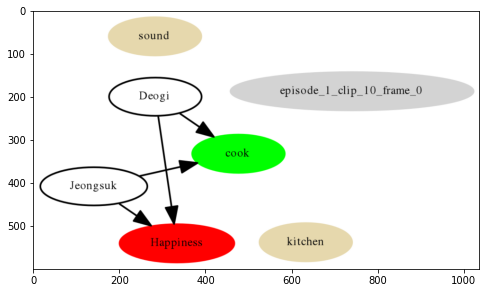

In [48]:
clip = 10
images, info = train_set[clip]

image = images[frm].cpu().numpy()

imageInfo = cv2.cvtColor(np.transpose(image,(1,2,0)), cv2.COLOR_RGB2BGR)
place = info[frm]['place'][0]
sound = 'sound'
print("----------------------{}-th----------------frame".format(frm))

num_of_persons = len(info[frm]['persons']['person_id'])
print("place:{}".format(place))
print("num_of_persons:{}".format(num_of_persons))

graph(episode, clip, frm, info[frm])

----------------------0-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


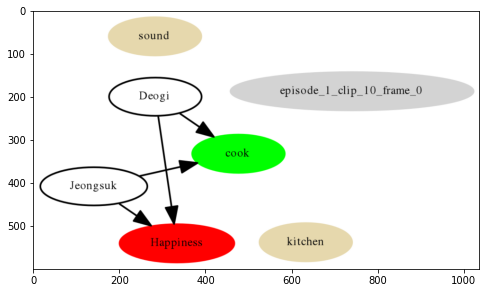

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[632, 93, 679, 157]
full_rect:[571, 41, 748, 382]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[306, 377, 399, 466]
full_rect:[255, 343, 456, 654]
behavior:cook
predicate:
emotion:Happiness


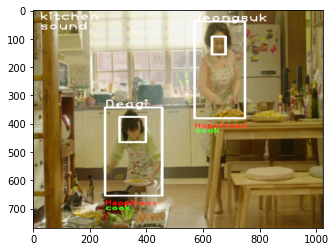

----------------------1-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


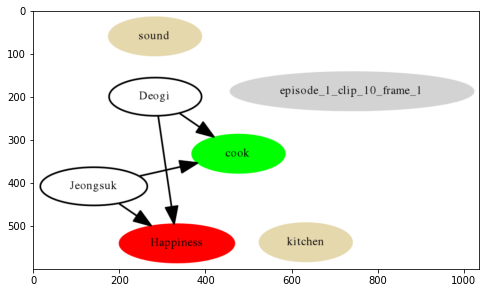

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[649, 106, 699, 183]
full_rect:[587, 41, 764, 382]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[306, 392, 399, 481]
full_rect:[255, 343, 456, 654]
behavior:cook
predicate:
emotion:Happiness


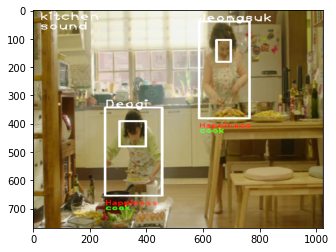

----------------------2-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


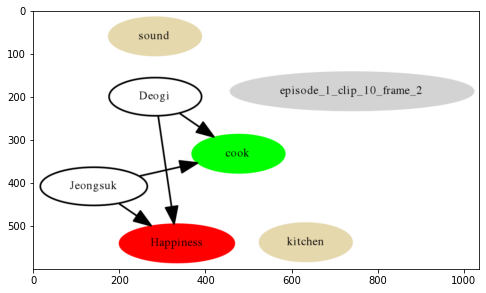

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[667, 104, 737, 179]
full_rect:[621, 35, 798, 376]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[314, 378, 407, 467]
full_rect:[264, 343, 465, 654]
behavior:cook
predicate:
emotion:Happiness


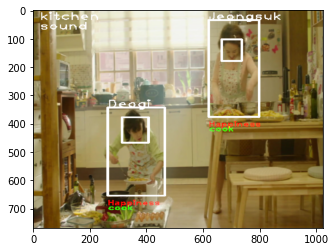

----------------------3-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


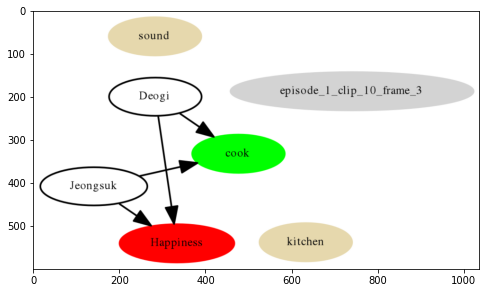

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[668, 104, 738, 181]
full_rect:[638, 31, 815, 372]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[314, 397, 407, 486]
full_rect:[264, 343, 465, 654]
behavior:cook
predicate:
emotion:Happiness


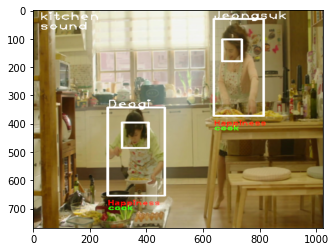

----------------------4-th----------------frame
place:kitchen
num_of_persons:2
place:kitchen
sound:sound
person_id:Jeongsuk
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
behavior:cook
predicate:
emotion:Happiness


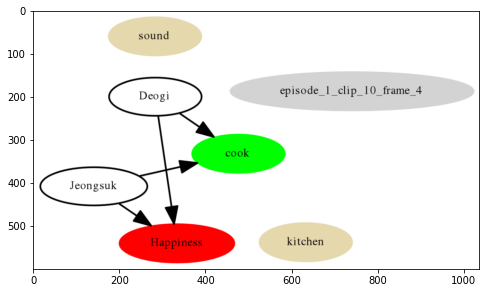

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


person_id:Jeongsuk
face_rect:[668, 104, 738, 181]
full_rect:[638, 31, 815, 372]
behavior:cook
predicate:
emotion:Happiness
person_id:Deogi
face_rect:[314, 397, 407, 486]
full_rect:[264, 343, 465, 654]
behavior:cook
predicate:
emotion:Happiness


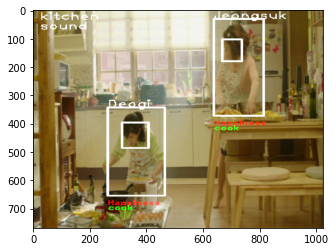

In [49]:
clip = 10
images, info = train_set[clip]

# visualize the images and labels
height, width = (768, 1024)
width_ratio = 448 / width
height_ratio = 448 / height

#print("num_images:{}".format(len(images)))
#print("info:\n{}".format(info))

for frm in range(len(images)):
    image = images[frm].cpu().numpy()

    imageInfo = cv2.cvtColor(np.transpose(image,(1,2,0)), cv2.COLOR_RGB2BGR)
    place = info[frm]['place'][0]
    sound = 'sound'
    print("----------------------{}-th----------------frame".format(frm))
    
    #episode = infos['episode']
    #clip = infos['clip'] 
    #s_time = infos['start_time']
    #e_time = infos['end_time']
    #print("episode:{}, clip:{}, time:{}->{}".format(
    #    episode, clip, s_time, e_time))
    
    num_of_persons = len(info[frm]['persons']['person_id'])
    print("place:{}".format(place))
    print("num_of_persons:{}".format(num_of_persons))
    
    graph(episode, clip, frm, info[frm])

    for p in range(num_of_persons):        
        person_id = info[frm]['persons']['person_id'][p]
        face_rect = info[frm]['persons']['face_rect'][p]
        full_rect = info[frm]['persons']['full_rect'][p]
            
        behavior = info[frm]['persons']['behavior'][p]
        predicate = info[frm]['persons']['predicate'][p]
        emotion = info[frm]['persons']['emotion'][p]
        
        print("person_id:{}".format(person_id))
        print("face_rect:{}".format(face_rect))
        print("full_rect:{}".format(full_rect))
        print("behavior:{}".format(behavior))
        print("predicate:{}".format(predicate))
        print("emotion:{}".format(emotion))

        # face rect
        xmin = int(max(face_rect[0] * width_ratio, 0))
        ymin = int(max(face_rect[1] * height_ratio, 0))
        xmax = int(min((face_rect[2]) * width_ratio, 448))
        ymax = int(min((face_rect[3]) * height_ratio, 448))
        cv2.rectangle(imageInfo, (xmin, ymin), (xmax, ymax), colors[0], 2)
        
        # full rect
        xmin = int(max(full_rect[0] * width_ratio, 0))
        ymin = int(max(full_rect[1] * height_ratio, 0))
        xmax = int(min((full_rect[2]) * width_ratio, 448))
        ymax = int(min((full_rect[3]) * height_ratio, 448))
        cv2.rectangle(imageInfo, (xmin, ymin), (xmax, ymax), colors[2], 2)
        cv2.putText(imageInfo, person_id, (xmin, ymin), 
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1)
        cv2.putText(imageInfo, emotion, (xmin, ymax+20), 
                    cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)
        cv2.putText(imageInfo, behavior, (xmin, ymax+30), 
                    cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0), 1)
        cv2.putText(imageInfo, place, (10, 20), 
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1)
        cv2.putText(imageInfo, sound, (10, 40), 
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1)
        
    imageInfo = cv2.cvtColor(imageInfo, cv2.COLOR_BGR2RGB)
    imageInfo = cv2.resize(imageInfo,dsize=(1024, 768))
    plt.imshow(imageInfo)
    plt.show()

In [ ]:
PersonCLS = ['Dokyung', 'Haeyoung1', 'Haeyoung2', 'Sukyung', 'Jinsang',
            'Taejin', 'Hun', 'Jiya', 'Kyungsu', 'Deogi',
            'Heeran', 'Jeongsuk', 'Anna', 'Hoijang', 'Soontack',
            'Sungjin', 'Gitae', 'Sangseok', 'Yijoon', 'Seohee', 'Unknown']

P2PRelCLS = ['Friendly', 'Unfriendly', 'Unknown']

ObjectCLS = ['Phone', 'Stick']
P2ORelCLS = ['Holding', 'Wearing', 'Unknown']

In [ ]:
def p2p_relation_digraph(p2p_rel):
    # define direct graph
    dot = Digraph(engine='dot')
    dot.attr('graph', rotate = '0', dpi='300',rankdir='TB', size='4,2')
    dot.attr('node', height='0.1', fontsize='10')
    dot.attr('edge', fontsize='10')

    for n in np.unique(p2p_rel[:, 0:2]): 
        dot.node(PersonCLS[n], shape='rectangle')

    for n in range(len(p2p_rel)): 
        rel = p2p_rel[n]
        dot.edge(PersonCLS[rel[0]], PersonCLS[rel[1]], label=P2PRelCLS[rel[1]])

    dot.format = 'png'
    dot.render('round-table.gv', view=True)

    graph = cv2.imread('round-table.gv.png')
    graph = cv2.resize(graph, dsize=(0, 0), fx=300.0/graph.shape[0], fy=300.0/graph.shape[0])
    plt.imshow(graph)
    plt.show()

p2p_rel = np.stack([[0,1,0], [0,2,1]])
p2p_relation_digraph(p2p_rel)